In [1]:
from test_denoiser import test_acc, show_random_batch, evaluate_metrics
from custom_dataset import get_dataloader
from models.denoisers import DnCNN, REDNet20
from utils import create_resnet
import torch
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#l2 attack eps
l2_eps = [0.5, 1.0, 2.0, 3.5]
#linf attack eps
linf_eps = [x/256 for x in [2, 5, 10, 16]]

#mnist
#dncnn
mnist_denoiser1 = DnCNN(in_channels=3, out_channels=3, depth=7, hidden_channels=64, use_bias=False).to(device)
mnist_denoiser1.load_state_dict(torch.load('./trained_denoisers/dncnn_mnist_mixed+gaussian.pth', map_location=device))
#dae denoiser
mnist_denoiser2 = REDNet20(in_channels=3, out_channels=3, use_bias=False).to(device)
mnist_denoiser2.load_state_dict(torch.load('./trained_denoisers/dae_mnist_mixed+gaussian.pth', map_location=device))

#cifar10
#dncnn
cifar10_denoiser1 = DnCNN(in_channels=3, out_channels=3, depth=7, hidden_channels=64, use_bias=False).to(device)
cifar10_denoiser1.load_state_dict(torch.load('./trained_denoisers/dncnn_cifar10_mixed+gaussian.pth', map_location=device))
cifar10_denoiser2 = DnCNN(in_channels=3, out_channels=3, depth=7, hidden_channels=64, use_bias=False).to(device)
cifar10_denoiser2.load_state_dict(torch.load('./trained_denoisers/dncnn_cifar10_mixed.pth', map_location=device))
cifar10_denoiser3 = DnCNN(in_channels=3, out_channels=3, depth=7, hidden_channels=64, use_bias=False).to(device)
cifar10_denoiser3.load_state_dict(torch.load('./trained_denoisers/dncnn_cifar10_gaussian.pth', map_location=device))
#dae
cifar10_denoiser4 = REDNet20(in_channels=3, out_channels=3, use_bias=False).to(device)
cifar10_denoiser4.load_state_dict(torch.load('./trained_denoisers/dae_cifar10_mixed+gaussian.pth', map_location=device))

#vanilla resnet model
#mnist
mnist_resnet = create_resnet(device=device, grayscale=True)
mnist_resnet.load_state_dict(torch.load('./trained_models/mnist/resnet18_2.0+0_BL.pth', map_location=device))
#cifar10
cifar10_resnet = create_resnet(device=device, grayscale=False)
cifar10_resnet.load_state_dict(torch.load('./trained_models/cifar10/resnet18_2.0+0_BL_junbo.pth', map_location=device))

#dataset loader
mnist_train_loader, mnist_test_loader = get_dataloader(dataset='mnist', batch_size=64, sample_test=True)
cifar10_train_loader, cifar10_test_loader = get_dataloader(dataset='cifar10', batch_size=64, sample_test=True)
print(len(mnist_train_loader.dataset))
print(len(mnist_test_loader.dataset))

Files already downloaded and verified
Files already downloaded and verified
60000
1024


In [2]:
import pickle
import os
import seaborn as sns


def run_test(test_loader, net, denoisers, attack_mode, eps_range, norm):
    #initialize result
    result = {}
    result['adv'] = []
    for i in range(len(denoisers)):
        result[f'dn{i+1}'] = []
        
    # cw
    if attack_mode == 'cw':
        accuracies_cw = test_acc(net, denoisers, test_loader, attack_mode, norm, eps=0.0)
        result['adv'].append(accuracies_cw[1])
        for i in range(len(denoisers)):
            result[f'dn{i+1}'].append(accuracies_cw[i+2])
        return result
        
    # fgsm/pgd
    for eps in eps_range:
        print("eps = ", eps)
        accuracies = test_acc(net, denoisers, test_loader, attack_mode, norm, eps)
        result['adv'].append(accuracies[1])
        for i in range(len(denoisers)):
            result[f'dn{i+1}'].append(accuracies[i+2])

    return result

def plot_mnist_result(result, attack, norm, eps_range, savefig=True, denoised2=True, self_compare=True):

    acc_list = unpack_dict(result)
    sns.set_theme(style="darkgrid")
    plt.figure(figsize=(10,7))
    plt.plot(eps_range, acc_list[0], marker='o', linewidth=1.5, markersize=3, label="No Denoiser")
    plt.plot(eps_range, acc_list[1], marker='o', linewidth=1.5, markersize=3, label="DnCNN - mixed")

    if denoised2 and self_compare:
        plt.plot(eps_range, acc_list[2], marker='o', linewidth=1.5, markersize=3, label="DnCNN - gaussian")
        plt.plot(eps_range, acc_list[2], marker='o', linewidth=1.5, markersize=3, label="DnCNN - fgsm + pgd")
        
    elif denoised2:
        plt.plot(eps_range, acc_list[2], marker='o', linewidth=1.5, markersize=3, label="AutoEncoder - mixed")

    plt.legend(loc="upper right")
    plt.xlabel('epsilon')
    plt.ylabel('model accuracy')
    plt.title(f"l-{norm} {attack} attack on MNIST")
    if savefig:
        if not os.path.exists('denosier_attack_figures'): os.mkdir('denosier_attack_figures')
        fig_name = f"mnist_{attack}_l{norm}.png"
        plt.savefig(os.path.join('denosier_attack_figures', fig_name), dpi=500)

    plt.show()

def plot_cifar10_result(result, attack, norm, eps_range, savefig=True):

    acc_list = unpack_dict(result)
    sns.set_theme(style="darkgrid")
    plt.figure(figsize=(10,7))
    plt.plot(eps_range, acc_list[0], marker='o', linewidth=1.5, markersize=3, label="No Denoiser")
    plt.plot(eps_range, acc_list[1], marker='o', linewidth=1.5, markersize=3, label="DnCNN - fgsm+pgd+gaussian")
    plt.plot(eps_range, acc_list[2], marker='o', linewidth=1.5, markersize=3, label="DnCNN - fgsm+pgd")
    plt.plot(eps_range, acc_list[3], marker='o', linewidth=1.5, markersize=3, label="DnCNN - gaussian")
    plt.plot(eps_range, acc_list[4], marker='o', linewidth=1.5, markersize=3, label="AutoEncoder - fgsm+pgd+gaussian")

    plt.legend(loc="upper right")
    plt.xlabel('epsilon')
    plt.ylabel('model accuracy')
    plt.title(f"l-{norm} {attack} attack on CIFAR10")
    if savefig:
        if not os.path.exists('denosier_attack_figures'): os.mkdir('denosier_attack_figures')
        fig_name = f"cifar10_{attack}_l{norm}.png"
        plt.savefig(os.path.join('denosier_attack_figures', fig_name), dpi=500)

    plt.show()
    

def save_result(filename, result, root='denoiser_attack_results', overwrite=False):
    if not os.path.exists(root): os.mkdir(root)

    file_path = os.path.join(root, filename)
    if os.path.exists(file_path) and (not overwrite):
        print("Updating pickle file")
        prev_result = load_result(file_path)
        prev_result.update(result)
        result = prev_result
        
    with open(file_path, 'wb') as f:
        pickle.dump(result, f, protocol=pickle.HIGHEST_PROTOCOL)


def load_result(file_path):
    if not os.path.exists(file_path):
        raise ValueError("Results file not found.")
    
    with open(file_path, "rb") as f:
        result = pickle.load(f)
    
    return result


def unpack_dict(result_dict):
    acc_list = []
    for key in result_dict:
        acc = result_dict[key]
        acc_list.append(acc)
    return acc_list


In [ ]:
# run mnist
# mnist_denoisers = [mnist_denoiser1, mnist_denoiser2]
# print("Running experiment on MNIST ...")
# for attack in ['fgsm', 'pgd', 'cw']:
#     if attack == 'cw':
#         # print(f"\nEvaluating C&W attack ...")
#         # file_name = f"mnist_{attack}.pkl"
#         # result = run_test(mnist_test_loader, mnist_resnet, mnist_denoisers, attack, [0.0], norm=1)
#         # save_result(file_name, result, overwrite=True)
#         continue

#     for norm in ['2', 'inf']:
#         print(f"\nEvaluating {attack} attack on l{norm} norm ...")
#         file_name = f"mnist_{attack}_l{norm}.pkl"
#         # convert norm
#         if norm == '2':
#             eps_range = l2_eps
#             norm = int(norm)
#         else:
#             eps_range = linf_eps
#             norm = np.inf
        
#         result = run_test(mnist_test_loader, mnist_resnet, mnist_denoisers, attack, eps_range, norm=norm)
#         save_result(file_name, result, overwrite=True)


# run cifar10
cifar10_denoisers = [cifar10_denoiser1, cifar10_denoiser2, cifar10_denoiser3, cifar10_denoiser4]
print("Running experiment on CIFAR10 ...")
for attack in ['fgsm', 'pgd', 'cw']:
    if attack == 'cw':
        # print(f"\nEvaluating C&W attack ...")
        # file_name = f"cifar10_{attack}.pkl"
        # result = run_test(cifar10_test_loader, cifar10_resnet, cifar10_denoisers, attack, [0.0], norm=1)
        # save_result(file_name, result, overwrite=True)
        continue

    for norm in ['2', 'inf']:
        print(f"\nEvaluating {attack} attack on l{norm} norm ...")
        file_name = f"cifar10_{attack}_l{norm}.pkl"
        #file_name = f"cifar10_{attack}_l{norm}_gaussian.pkl"
        # convert norm
        if norm == '2':
            eps_range = l2_eps
            norm = int(norm)
        else:
            eps_range = linf_eps
            norm = np.inf
        
        result = run_test(cifar10_test_loader, cifar10_resnet, cifar10_denoisers, attack, eps_range, norm=norm)
        save_result(file_name, result, overwrite=True)    

In [ ]:
#plot mnist
for attack in ['fgsm', 'pgd']:
    for norm in ['2', 'inf']:
        #print(f"\nEvaluating {attack} attack on l{norm} norm ...")
        file_path = os.path.join('denoiser_attack_results', f"mnist_{attack}_l{norm}.pkl")
        result = load_result(file_path)
        plot_mnist_result(result, attack, norm, eps_range=l2_eps if (norm == '2') else linf_eps, savefig=True, self_compare=False)

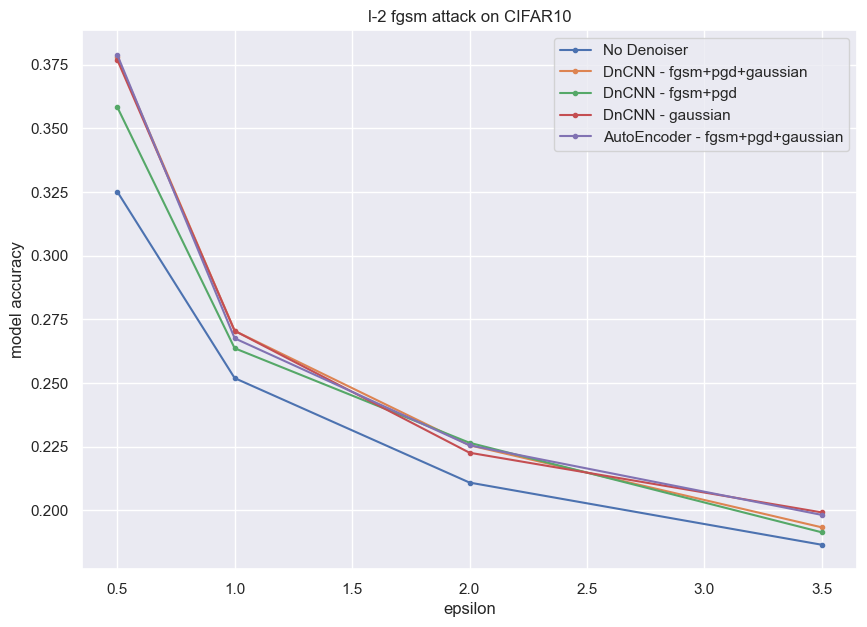

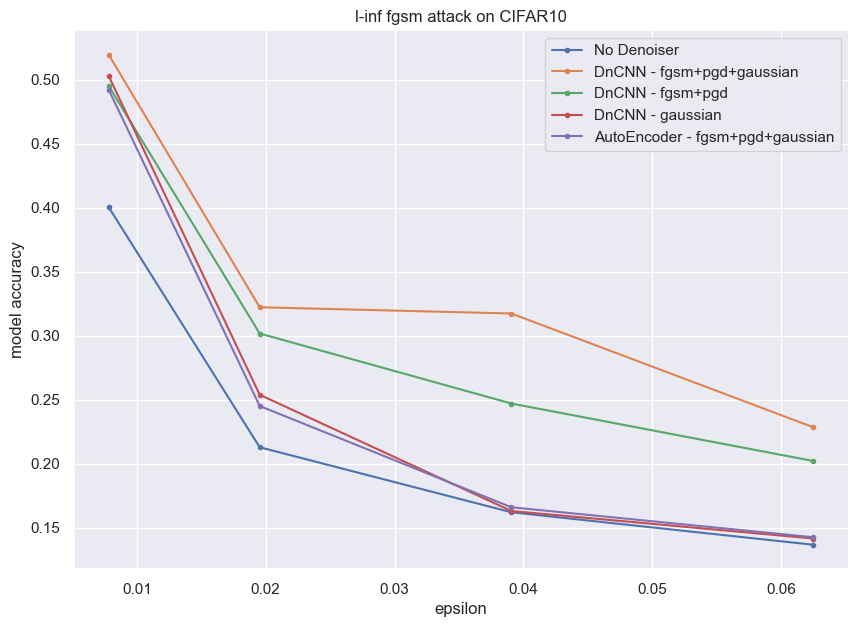

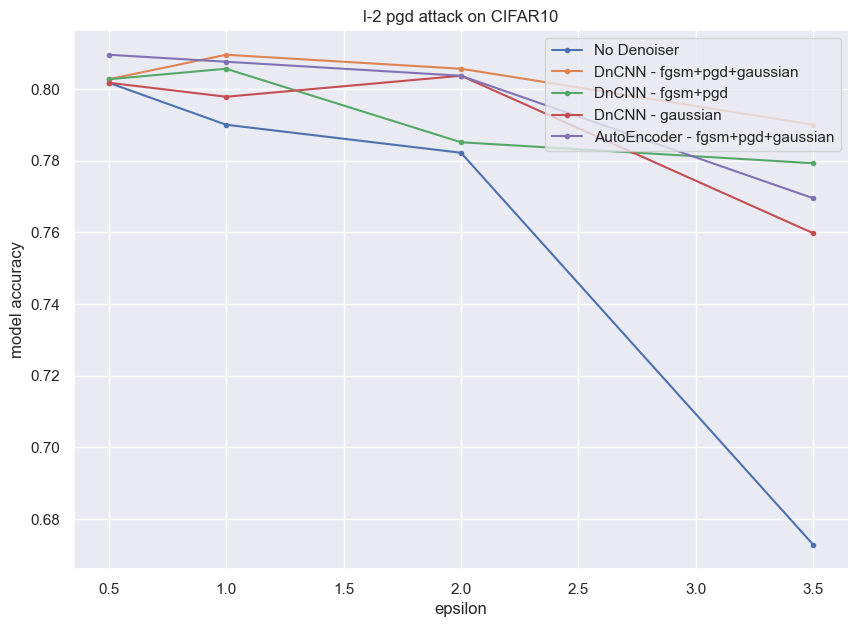

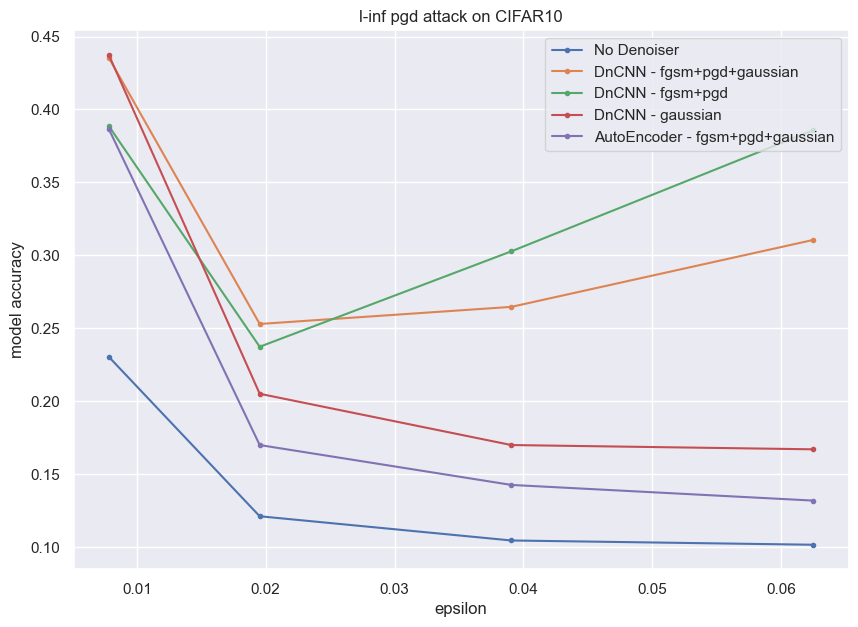

In [3]:
#plot cifar10
for attack in ['fgsm', 'pgd']:
    for norm in ['2', 'inf']:
        #print(f"\nEvaluating {attack} attack on l{norm} norm ...")
        file_path = os.path.join('denoiser_attack_results', f"cifar10_{attack}_l{norm}.pkl")
        result = load_result(file_path)
        plot_cifar10_result(result, attack, norm, eps_range=l2_eps if (norm == '2') else linf_eps, savefig=True)

In [2]:
evaluate_metrics(cifar10_resnet, cifar10_denoiser1, cifar10_test_loader, attack='fgsm', norm=np.inf, eps=0.0625)
evaluate_metrics(cifar10_resnet, cifar10_denoiser1, cifar10_test_loader, attack='pgd', norm=np.inf, eps=0.0625)

  0%|          | 0/16 [00:00<?, ?it/s]c:\Users\junbo\Downloads\csc2529_project\test_denoiser.py:115: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  avg_ssim += SSIM(original, denoised, multichannel=True)
100%|██████████| 16/16 [00:03<00:00,  4.99it/s]



Average PSNR:30.711 
Average SSIM: 0.967


100%|██████████| 16/16 [00:12<00:00,  1.32it/s]


Average PSNR:33.709 
Average SSIM: 0.980


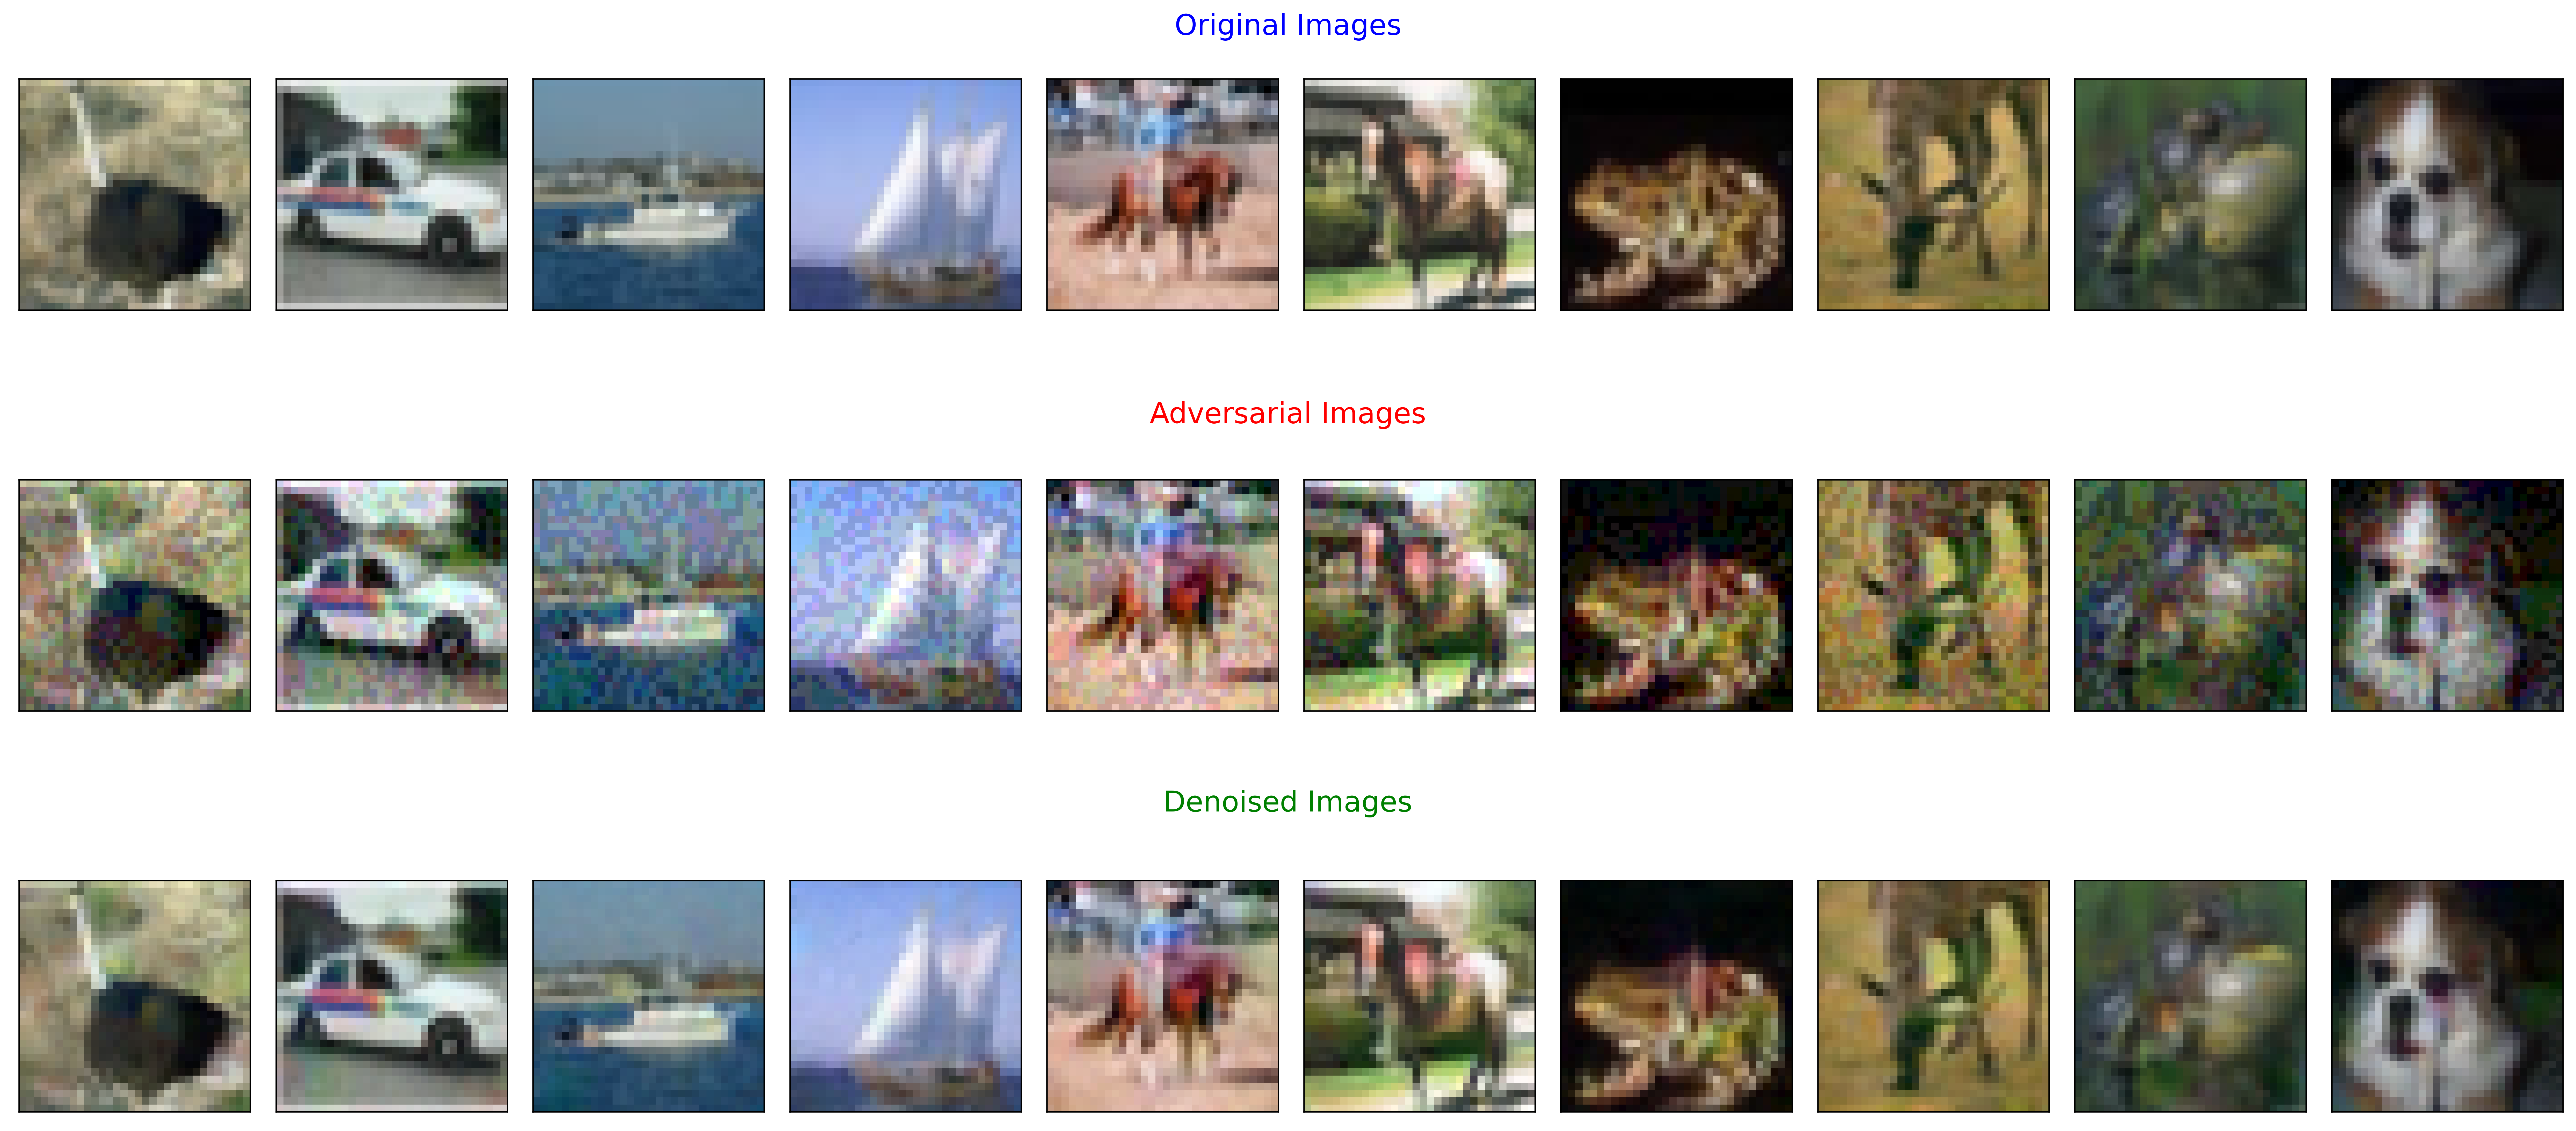

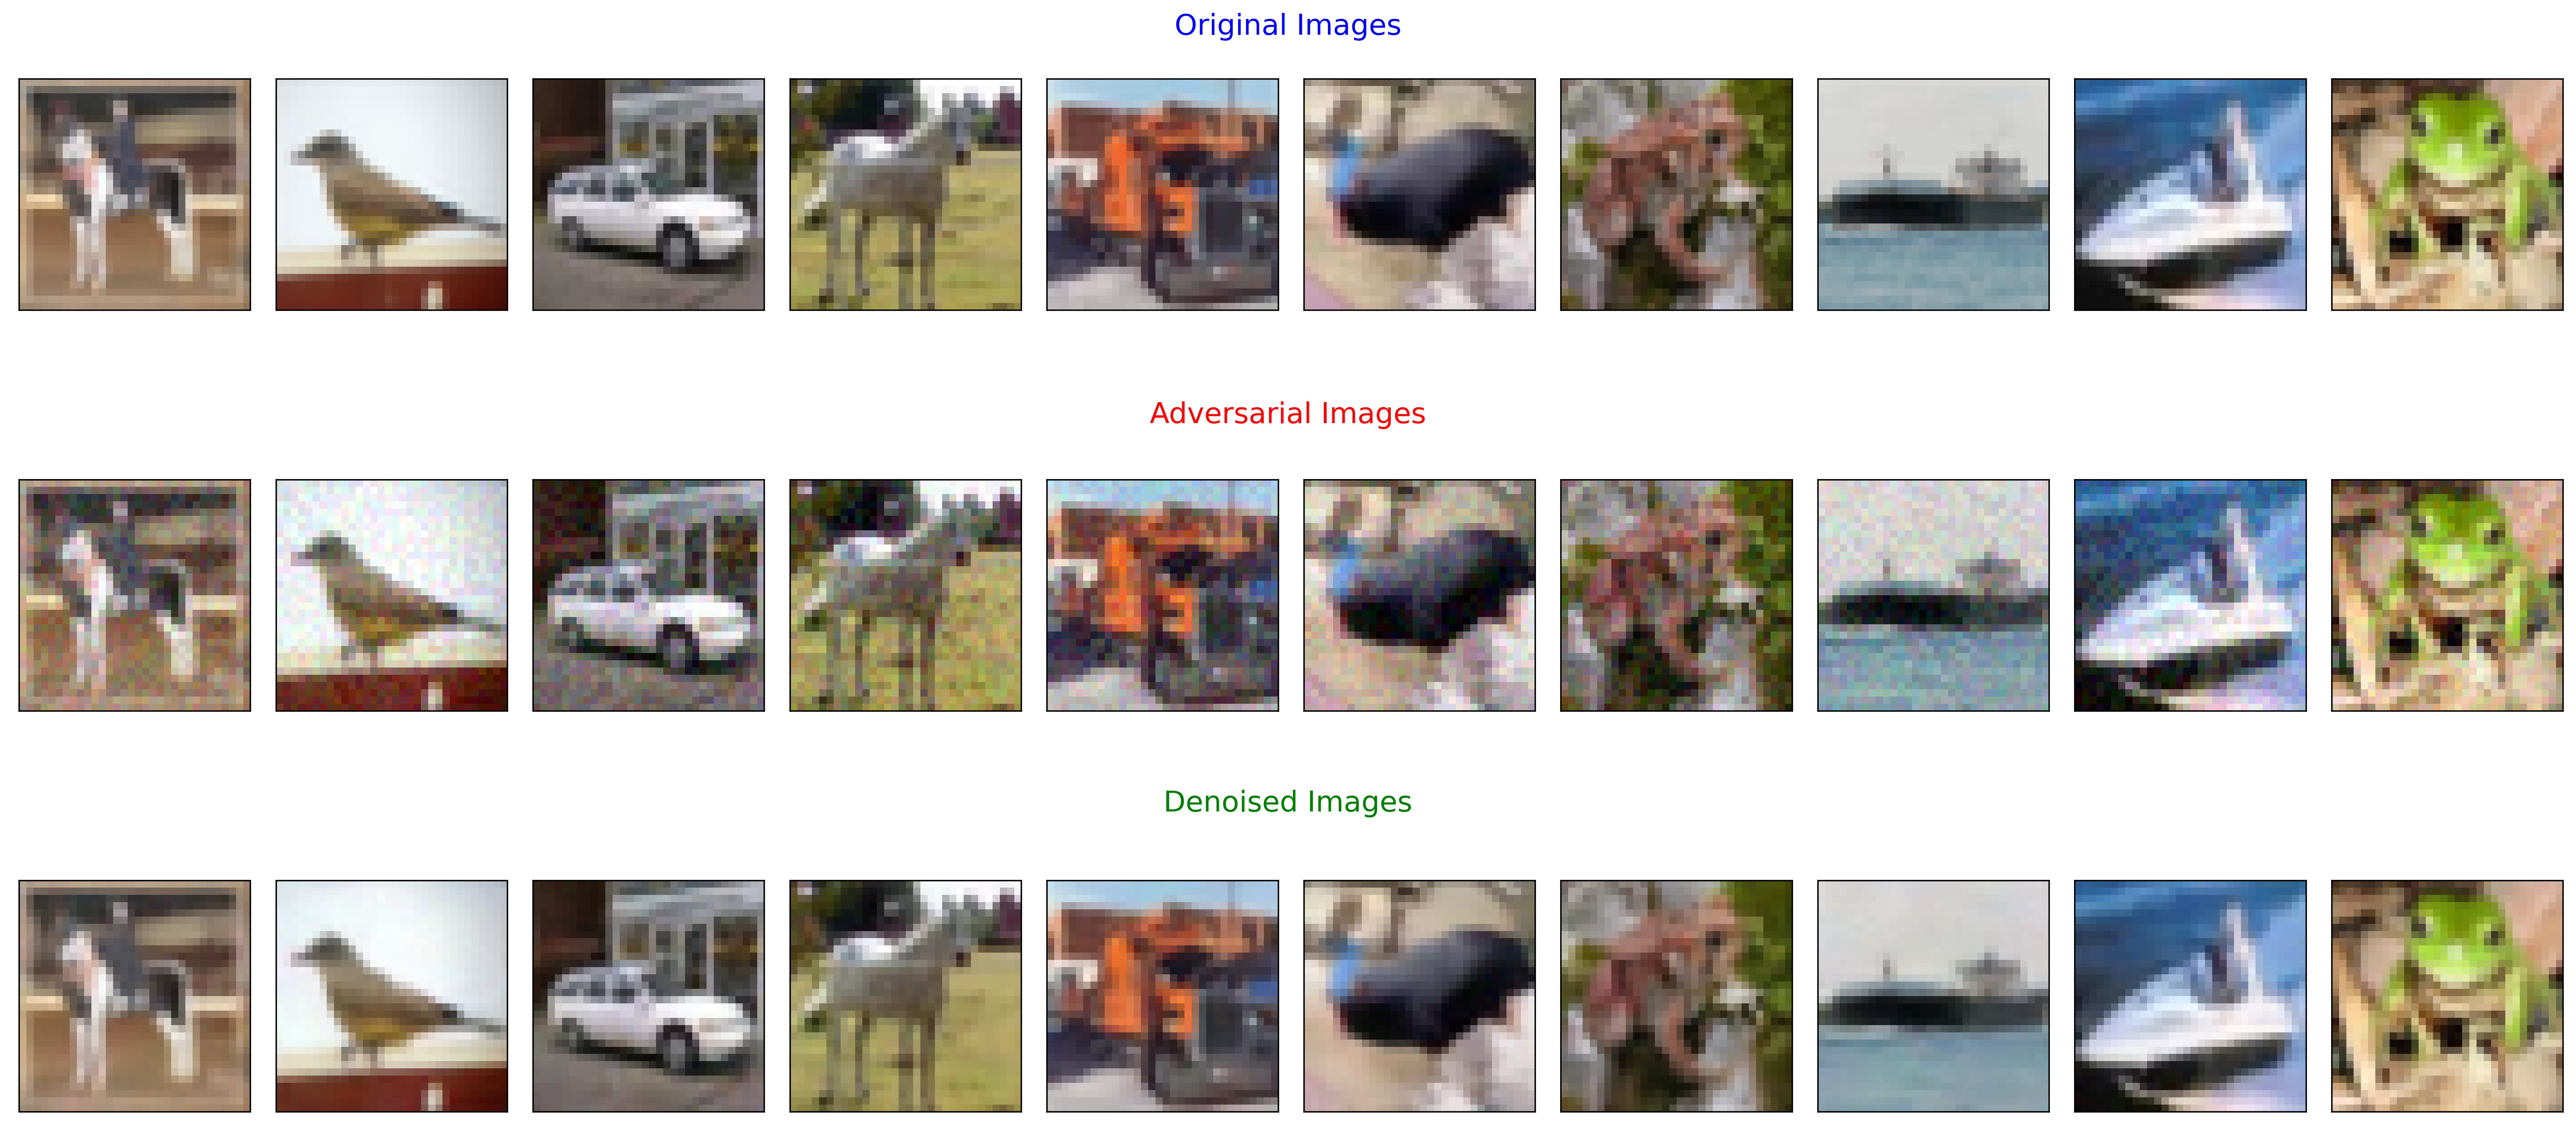

In [3]:
#show_random_batch(mnist_resnet, mnist_denoiser1, mnist_test_loader, attack='fgsm', norm=np.inf, eps=0.0625)
show_random_batch(cifar10_resnet, cifar10_denoiser1, cifar10_train_loader, attack='fgsm', norm=np.inf, eps=0.0625, n=10)
show_random_batch(cifar10_resnet, cifar10_denoiser1, cifar10_train_loader, attack='pgd', norm=np.inf, eps=0.0625, n=10)

In [ ]:
import torch
x = torch.ones((4, 4)) / 2
y = torch.ones((2, 3, 4, 4))
yy = torch.randn_like(y[:, 0, :, :].unsqueeze(1))

#print(x)
z = x + y
print(z.size())
#print(z)
print(y.shape[-1])
print(y.shape[-2])
print(yy.shape)

In [ ]:
import torch
x = torch.tensor([-0.2, 0.3, 1.5])
print(torch.clamp(x, 0, 1))

In [ ]:
import numpy as np

a = np.array([1, 2, 3])
b = np.array([4, 5, 6])
print(a-b)
print(np.sum(a-b))

In [ ]:
x = {'a': [1,2], 'b': 2}
y = {'a': [3,4], 'b': 4}
print(x)
x['a'] = y['a']
print(x)

In [ ]:
indices = torch.randperm(10000)[:1000]
print(indices.size())

In [ ]:
acc_list = np.zeros((3))
print(acc_list)
acc_list[0] += 1
print(acc_list)